# Testing portfolios

In this notebook we illustrate how to implement different strategies on a single stock. We aim to compare the different results obtained in order to understand how different strategies provide different values for the risk metrics. The risk metrics are provided by PyFolio.

We will be working with a single stock, which we choose to be AAPL (Apple).

Recall that implementing a backtest on zipline requires the definition of three functions:

- initialize
- handle_data
- analyze

We will be modifying this functions on every test in order to ilustrate how to use zipline functionalities.

***

## Section 0

In this section we import the libraries necessary for our analysis.

In [2]:
######################################################## Importing necessary libraries
%matplotlib inline
from zipline import run_algorithm
from zipline.api import order_target, order_target_percent, \
    symbol, set_benchmark, schedule_function, \
    date_rules, time_rules, get_datetime
from datetime import datetime
import pytz
import matplotlib.pyplot as plt
import pyfolio as pf
import numpy as np
import pandas as pd
from scipy import stats 

***

## Section 1
### Test 1 : Long only

We first implement a long only strategy with no benchmark. We use a starting capital base of 10,000USD and we only buy 5 shares of AAPL.

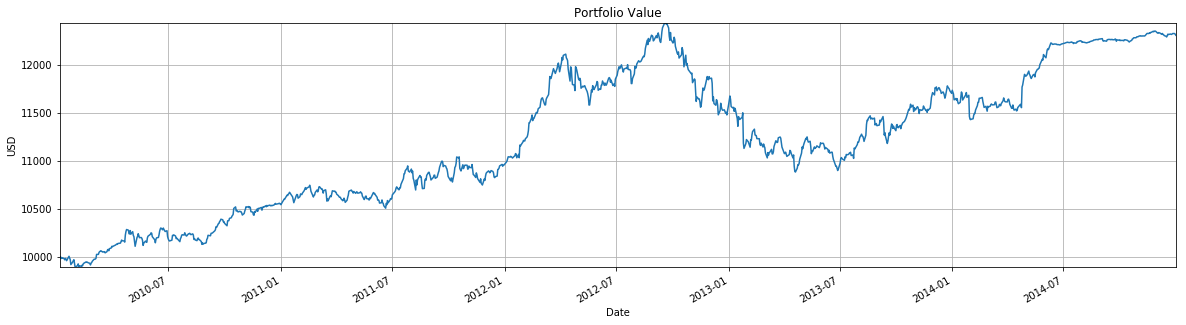

In [3]:
######################################################## Defining zipline basic functions

def initialize(context):
    # Stock to trade
    context.stock = symbol('AAPL')
    
def handle_data(context, data):
    # Always long on AAPL
    stock_size = 5    
    # Trading
    order_target(context.stock, stock_size)

def analyze(context, perf):
    # We plot only the portfolio value
    ax = perf['portfolio_value'].plot(title='Portfolio Value', figsize=(20,5))
    ax.set_xlim(perf.index.min(), perf.index.max())
    ax.set_ylim(perf['portfolio_value'].min(), perf['portfolio_value'].max())
    plt.xlabel('Date')
    plt.ylabel('USD')
    plt.rcParams.update({'font.size': 20})
    plt.grid(True)


######################################################## Running Backtest
start_date = datetime(2010, 1, 1, tzinfo=pytz.UTC)
end_date = datetime(2015, 1, 1, tzinfo=pytz.UTC)

# Fire off the backtest
results = run_algorithm(
    start=start_date,
    end=end_date,
    initialize=initialize,
    analyze=analyze,
    handle_data=handle_data,
    capital_base=10000,
    data_frequency = 'daily', bundle='quandl'
)

Below we use the function __show_perf_stats__ to compute a few risk metrics provided by PyFolio.

In [4]:
pf.utils.extract_rets_pos_txn_from_zipline(results)[0]

2010-01-04 00:00:00+00:00    0.000000
2010-01-05 00:00:00+00:00   -0.000054
2010-01-06 00:00:00+00:00   -0.001705
2010-01-07 00:00:00+00:00   -0.000195
2010-01-08 00:00:00+00:00    0.000701
2010-01-11 00:00:00+00:00   -0.000936
2010-01-12 00:00:00+00:00   -0.001198
2010-01-13 00:00:00+00:00    0.001470
2010-01-14 00:00:00+00:00   -0.000611
2010-01-15 00:00:00+00:00   -0.001754
2010-01-19 00:00:00+00:00    0.004575
2010-01-20 00:00:00+00:00   -0.001657
2010-01-21 00:00:00+00:00   -0.001829
2010-01-22 00:00:00+00:00   -0.005178
2010-01-25 00:00:00+00:00    0.002685
2010-01-26 00:00:00+00:00    0.001441
2010-01-27 00:00:00+00:00    0.000976
2010-01-28 00:00:00+00:00   -0.004311
2010-01-29 00:00:00+00:00   -0.003641
2010-02-01 00:00:00+00:00    0.001349
2010-02-02 00:00:00+00:00    0.000571
2010-02-03 00:00:00+00:00    0.001701
2010-02-04 00:00:00+00:00   -0.003618
2010-02-05 00:00:00+00:00    0.001724
2010-02-08 00:00:00+00:00   -0.000676
2010-02-09 00:00:00+00:00    0.001046
2010-02-10 0

In [5]:
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(results)
test_1 = pf.timeseries.perf_stats(returns)
pf.show_perf_stats(returns)

***

## Section 2
### Test 2 : Long only with double exposure

We implement the same strategy as in Section 1, but we double our exposure to 10 shares of AAPL.

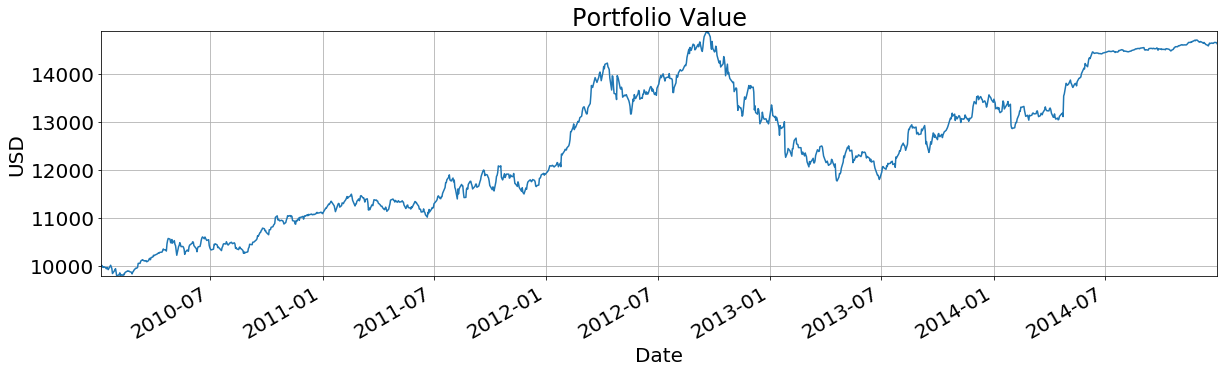

In [4]:
######################################################## Defining zipline basic functions

def initialize(context):
    # Stock to trade
    context.stock = symbol('AAPL')
    
def handle_data(context, data):
    # Always long on AAPL
    stock_size = 10    
    # Trading
    order_target(context.stock, stock_size)

def analyze(context, perf):
    # We plot only the portfolio value
    ax = perf['portfolio_value'].plot(title='Portfolio Value', figsize=(20,5))
    ax.set_xlim(perf.index.min(), perf.index.max())
    ax.set_ylim(perf['portfolio_value'].min(), perf['portfolio_value'].max())
    plt.xlabel('Date')
    plt.ylabel('USD')
    plt.rcParams.update({'font.size': 20})
    plt.grid(True)


######################################################## Running Backtest
start_date = datetime(2010, 1, 1, tzinfo=pytz.UTC)
end_date = datetime(2015, 1, 1, tzinfo=pytz.UTC)

# Fire off the backtest
results = run_algorithm(
    start=start_date,
    end=end_date,
    initialize=initialize,
    analyze=analyze,
    handle_data=handle_data,
    capital_base=10000,
    data_frequency = 'daily', bundle='quandl'
)

Let us print the risk metrics provided by PyFolio. We observe the following : 

- Annual return doubles (more or less) and volatility as well. Max drawdown doubles too.
- Ratios stay (more or less) constant.

This is as excpeted, since what we only double our expousure on AAPL.

In [5]:
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(results)
test_2 = pf.timeseries.perf_stats(returns)
pf.show_perf_stats(returns)

***

## Section 3
### Test 3 : Moving average

We now implement a strategy based on a particular signal: moving average. We will buy 10 units of AAPL if the price is above the 30 day moving average. Otherwise we sell and hold cash only.

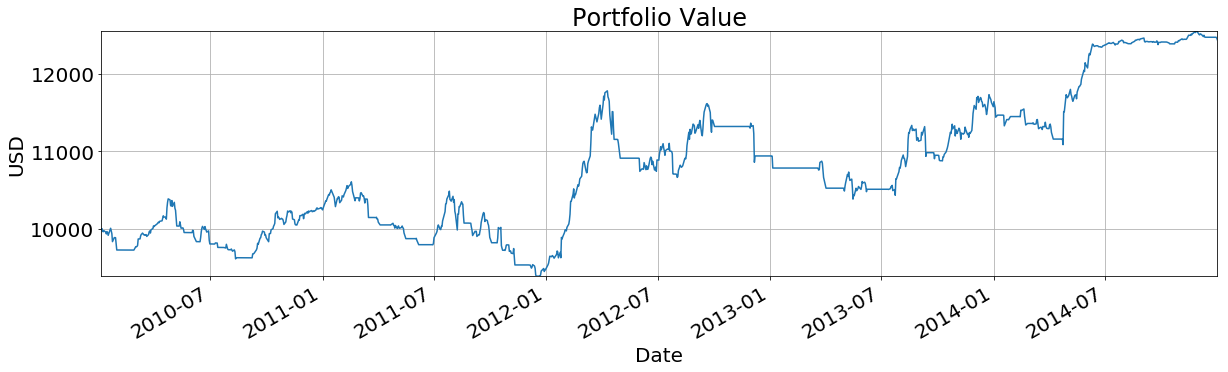

In [6]:
######################################################## Defining zipline basic functions

def initialize(context):
    # Stock to trade
    context.stock = symbol('AAPL')
    # Moving average window
    context.index_average_window = 30
    
def handle_data(context, data):
    # Request history for the stock
    equities_hist = data.history(context.stock, "close", context.index_average_window, "1d")
    
    # Check if price is above moving average
    if equities_hist[-1] > equities_hist.mean():
        stock_size = 10
    else:
        stock_size = 0

    # Trading
    order_target(context.stock, stock_size)

def analyze(context, perf):
    # We plot only the portfolio value
    ax = perf['portfolio_value'].plot(title='Portfolio Value', figsize=(20,5))
    ax.set_xlim(perf.index.min(), perf.index.max())
    ax.set_ylim(perf['portfolio_value'].min(), perf['portfolio_value'].max())
    plt.xlabel('Date')
    plt.ylabel('USD')
    plt.rcParams.update({'font.size': 20})
    plt.grid(True)


######################################################## Running Backtest
start_date = datetime(2010, 1, 1, tzinfo=pytz.UTC)
end_date = datetime(2015, 1, 1, tzinfo=pytz.UTC)

# Fire off the backtest
results = run_algorithm(
    start=start_date,
    end=end_date,
    initialize=initialize,
    analyze=analyze,
    handle_data=handle_data,
    capital_base=10000,
    data_frequency = 'daily', bundle='quandl'
)

Below we print the risk metrics of this strategy. We observe the following:

- Compared to test 2, we obtain a lower return and a lower volatility. However, this strategy has worse results than the strategy in test 1 in terms of risk/return trade off.

- The max drawdown is lower for this test than for the previous test. 

We could conclude based on this observations that this strategy is more conservative.

In [7]:
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(results)
test_3 = pf.timeseries.perf_stats(returns)
pf.show_perf_stats(returns)

***

## Section 4
### Test 4 : Moving average

We the same strategy as above but using a 90 day moving average.

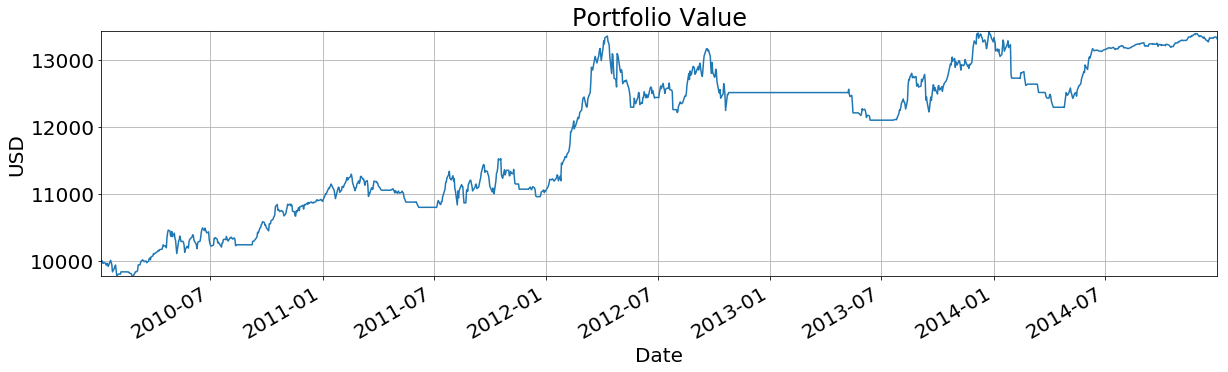

In [8]:
######################################################## Defining zipline basic functions

def initialize(context):
    # Stock to trade
    context.stock = symbol('AAPL')
    # Moving average window
    context.index_average_window = 90
    
def handle_data(context, data):
    # Request history for the stock
    equities_hist = data.history(context.stock, "close", context.index_average_window, "1d")
    
    # Check if price is above moving average
    if equities_hist[-1] > equities_hist.mean():
        stock_size = 10
    else:
        stock_size = 0

    # Trading
    order_target(context.stock, stock_size)

def analyze(context, perf):
    # We plot only the portfolio value
    ax = perf['portfolio_value'].plot(title='Portfolio Value', figsize=(20,5))
    ax.set_xlim(perf.index.min(), perf.index.max())
    ax.set_ylim(perf['portfolio_value'].min(), perf['portfolio_value'].max())
    plt.xlabel('Date')
    plt.ylabel('USD')
    plt.rcParams.update({'font.size': 20})
    plt.grid(True)


######################################################## Running Backtest
start_date = datetime(2010, 1, 1, tzinfo=pytz.UTC)
end_date = datetime(2015, 1, 1, tzinfo=pytz.UTC)

# Fire off the backtest
results = run_algorithm(
    start=start_date,
    end=end_date,
    initialize=initialize,
    analyze=analyze,
    handle_data=handle_data,
    capital_base=10000,
    data_frequency = 'daily', bundle='quandl'
)

We see an interesting improvement with respect to test 3 when implementing this strategy. The annual return increases and the annualized volatility is reduced. This is reflected on a higher Sharpe ratio. Based on this metric, we see that the strategy used on test 2 (buy and hold) is slightly better. However, Max drawdown is cut more than one half when following the 90 day moving average signal.

In [9]:
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(results)
test_4 = pf.timeseries.perf_stats(returns)
pf.show_perf_stats(returns)

***

## Section 5
### Test 5 : Momentum

We now implement a strategy where the buying signal is given by a measure of the momentum of AAPL. The momentum is computed in the function __momentum_score__, which we define below. This measure is taken from:

- 'Trading Evolved', Andreas F. Clenow, chapter : Systematic Momentum

If momentum is lower than __minimum_momentum__ we keep cash only, otherwise we go long 10 units of stock of AAPL.

In [10]:
momentum_window = 10
minimum_momentum = 10

def momentum_score(ts):
    """
    Input:  Price time series.
    Output: Annualized exponential regression slope, 
            multiplied by the R2
    """
    # Make a list of consecutive numbers
    x = np.arange(len(ts)) 
    # Get logs
    log_ts = np.log(ts) 
    # Calculate regression values
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, log_ts)
    # Annualize percent
    annualized_slope = (np.power(np.exp(slope), 252) - 1) * 100
    #Adjust for fitness
    score = annualized_slope * (r_value ** 2)
    return score

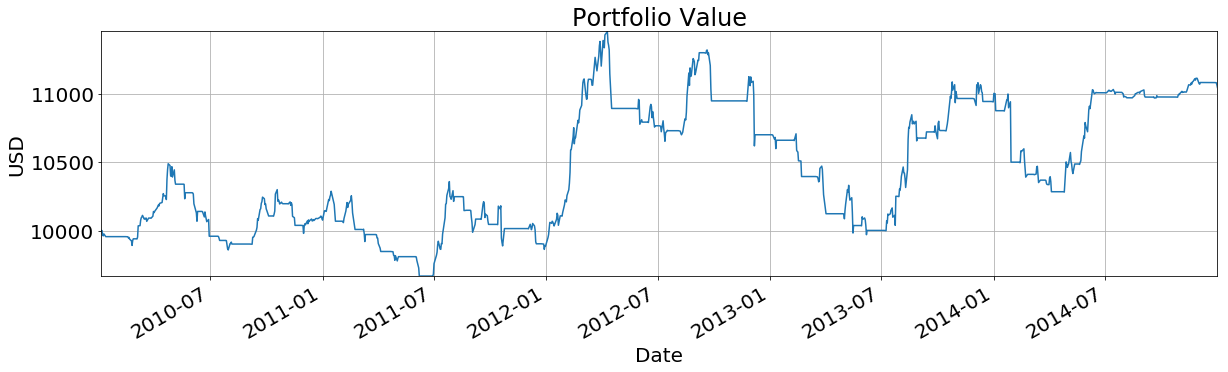

In [11]:
######################################################## Defining zipline basic functions

def initialize(context):
    # Stock to trade
    context.stock = symbol('AAPL')
    
def handle_data(context, data):
    # Request history for the stock
    equities_hist = data.history(context.stock, "close", momentum_window, "1d")
    
    # Computing momentum
    momentum = momentum_score(equities_hist)
    
    # Check if price is above moving average
    if momentum > minimum_momentum:
        stock_size = 10
    else:
        stock_size = 0

    # Trading
    order_target(context.stock, stock_size)

def analyze(context, perf):
    # We plot only the portfolio value
    ax = perf['portfolio_value'].plot(title='Portfolio Value', figsize=(20,5))
    ax.set_xlim(perf.index.min(), perf.index.max())
    ax.set_ylim(perf['portfolio_value'].min(), perf['portfolio_value'].max())
    plt.xlabel('Date')
    plt.ylabel('USD')
    plt.rcParams.update({'font.size': 20})
    plt.grid(True)


######################################################## Running Backtest
start_date = datetime(2010, 1, 1, tzinfo=pytz.UTC)
end_date = datetime(2015, 1, 1, tzinfo=pytz.UTC)

# Fire off the backtest
results = run_algorithm(
    start=start_date,
    end=end_date,
    initialize=initialize,
    analyze=analyze,
    handle_data=handle_data,
    capital_base=10000,
    data_frequency = 'daily', bundle='quandl'
)

This strategy shows very poor results. Note that we compute momentum every day and and we buy or stay in if the value is greater than __minimum_momentum__. By observing at the graph above we see that we enter the market once the price starts to increase, but we fail to exit in due time. We stay since the momentum might still be high even the price is increasing. 

In [12]:
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(results)
test_5 = pf.timeseries.perf_stats(returns)
pf.show_perf_stats(returns)

***

## Section 6
### Test 6 : Momentum

We will now implement a variation of the strategy above. We will use the same momentum score as signal with the same __momentum_window__, but we will do the following modifications : 

- we will only trade monthly
- we will rise the __minimum_momentum__ requirement

This will help us capture the momentum of the last 10 days of each month, and only trade when this metric has a high value.

Note : we modify here the __run_algorithm__ function in the following manner. We do not include the __handle_data__ variable as a parameter. Instead, we call the __schedule_function__ (provided by the zipline API) in the __initialize__ function, and it is here where we indicate that we want to trade only at the beginning of each month.

In [13]:
momentum_window = 10
minimum_momentum = 50

def momentum_score(ts):
    """
    Input:  Price time series.
    Output: Annualized exponential regression slope, 
            multiplied by the R2
    """
    # Make a list of consecutive numbers
    x = np.arange(len(ts)) 
    # Get logs
    log_ts = np.log(ts) 
    # Calculate regression values
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, log_ts)
    # Annualize percent
    annualized_slope = (np.power(np.exp(slope), 252) - 1) * 100
    #Adjust for fitness
    score = annualized_slope * (r_value ** 2)
    return score

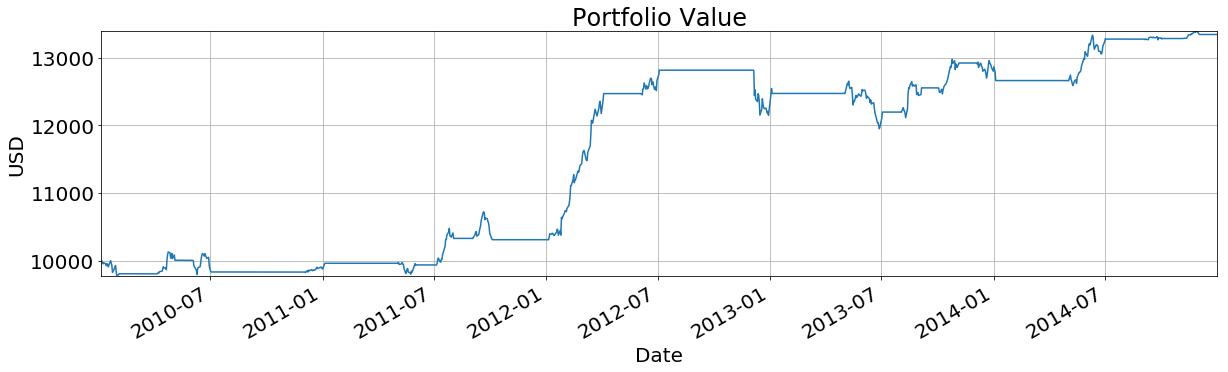

In [14]:
######################################################## Defining zipline basic functions

def initialize(context):
    # Stock to trade
    context.stock = symbol('AAPL')
    
    #Schedule rebalance monthly.
    schedule_function(
        func=handle_data,
        date_rule=date_rules.month_start(),
        time_rule=time_rules.market_open()
    )
    
    
def handle_data(context, data):
    # Request history for the stock
    equities_hist = data.history(context.stock, "close", momentum_window, "1d")
    
    # Computing momentum
    momentum = momentum_score(equities_hist)
    
    # Check if momentum is above minimum momentum
    if momentum > minimum_momentum :
        stock_size = 10
    else:
        stock_size = 0

    # Trading
    order_target(context.stock, stock_size)

def analyze(context, perf):
    # We plot only the portfolio value
    ax = perf['portfolio_value'].plot(title='Portfolio Value', figsize=(20,5))
    ax.set_xlim(perf.index.min(), perf.index.max())
    ax.set_ylim(perf['portfolio_value'].min(), perf['portfolio_value'].max())
    plt.xlabel('Date')
    plt.ylabel('USD')
    plt.rcParams.update({'font.size': 20})
    plt.grid(True)


######################################################## Running Backtest
start_date = datetime(2010, 1, 1, tzinfo=pytz.UTC)
end_date = datetime(2015, 1, 1, tzinfo=pytz.UTC)

# Fire off the backtest
results = run_algorithm(
    start=start_date,
    end=end_date,
    initialize=initialize,
    analyze=analyze,
    #handle_data=handle_data,
    capital_base=10000,
    data_frequency = 'daily', bundle='quandl'
)

This strategy provides us with the best Sharpe ratio of all strategies mentioned above. In fact, we can say the same for most of the metrics under consideration. While it is true the buy and hold strategy has a better return, in terms of risk adjusted metrics the the monthly momentum strategy is more performant.

In [15]:
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(results)
test_6 = pf.timeseries.perf_stats(returns)
pf.show_perf_stats(returns)

***

## Section 7
### Comparing results

Below we print the results of all tests. Note we obtain pretty good results for test 6 in terms of ratios.

In [27]:
frame = {'test 1':test_1, 'test 2':test_2, 'test 3':test_3, 'test 4':test_4, 'test 5':test_5, 'test 6':test_6}
pd.DataFrame(frame)

test 1    test 2    test 3    test 4     test 5  \
Annual return        0.042434  0.078918  0.044684  0.058790   0.020160   
Cumulative returns   0.230552  0.461103  0.243866  0.330004   0.104771   
Annual volatility    0.051244  0.091834  0.077374  0.076308   0.063358   
Sharpe ratio         0.836670  0.873179  0.603657  0.786817   0.346789   
Calmar ratio         0.338799  0.376800  0.375996  0.624236   0.155154   
Stability            0.740969  0.746284  0.736061  0.846585   0.439146   
Max drawdown        -0.125249 -0.209443 -0.118841 -0.094180  -0.129935   
Omega ratio          1.170448  1.176777  1.148945  1.182927   1.098507   
Sortino ratio        1.214066  1.271503  0.884732  1.169929   0.479222   
Skew                -0.271552 -0.250734  0.173547  0.246170  -1.103297   
Kurtosis             9.107599  8.458313  9.475103  8.600500  17.994618   
Tail ratio           1.017278  1.010927  1.016466  1.059892   1.056951   
Daily value at risk -0.006286 -0.011252 -0.009563 -0.009376  -0.007895   

                        test 6  
Annual return         0.059425  
Cumulative returns    0.333986  
Annual volatility     0.051363  
Sharpe ratio          1.149633  
Calmar ratio          0.882599  
Stability             0.842716  
Max drawdown         -0.067329  
Omega ratio           1.405652  
Sortino ratio         1.848399  
Skew                  0.602048  
Kurtosis             14.294490  
Tail ratio            1.296245  
Daily value at risk  -0.006237